In [13]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import einops
from einops.layers.torch import Rearrange

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

In [2]:
class ImageDataset():
    def __init__(self, root_dir, transforms):
        self.root_dir = root_dir
        self.transform = transforms
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.image_files[idx].split('.')[0]
        
        return image, label

In [3]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageDataset(root_dir='/home/longnt/hdd/data/images', transforms=transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=1)

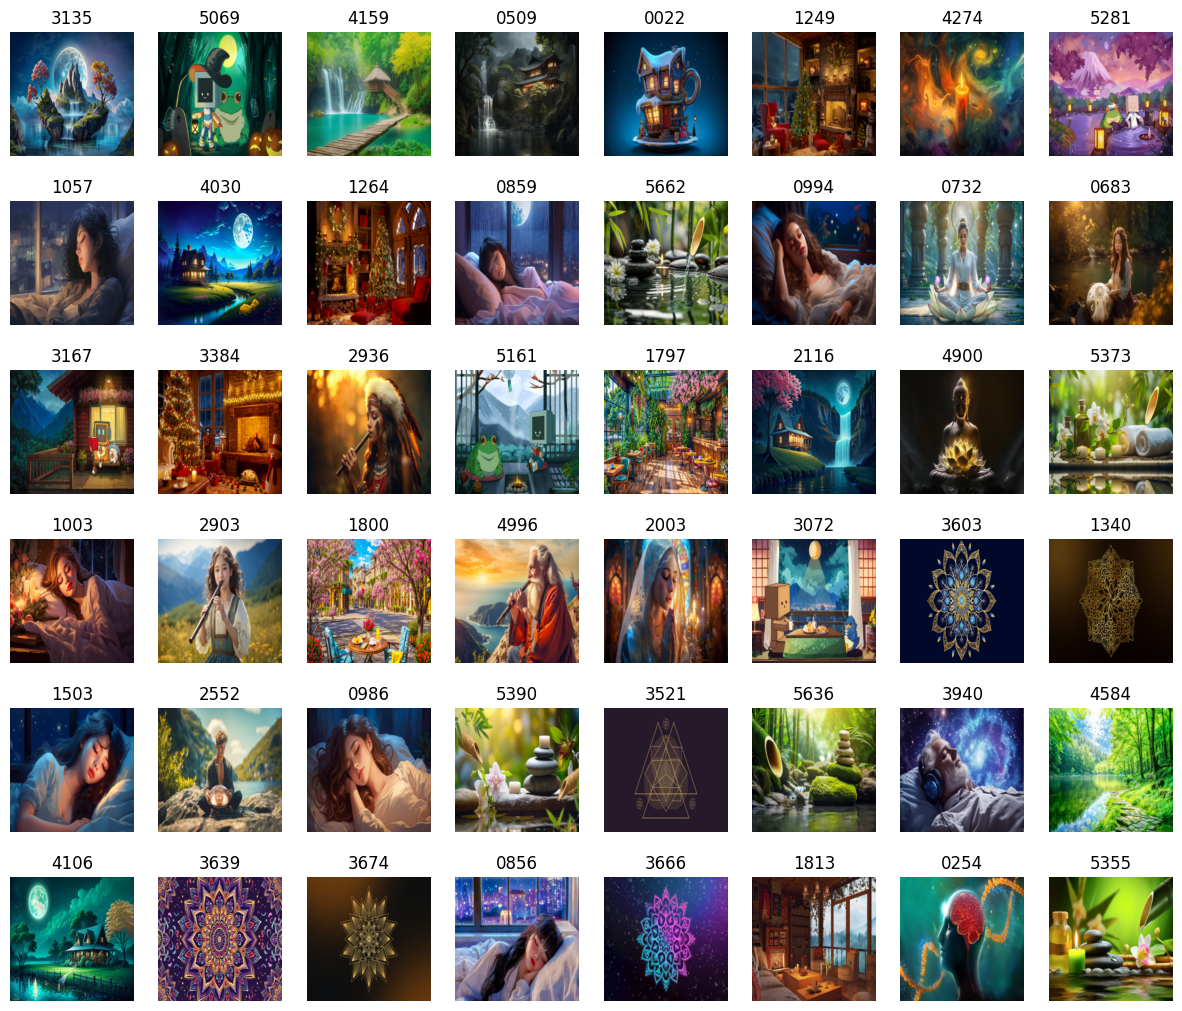

In [4]:
def show_images(dataset, num_samples=42, cols=8):
    plt.figure(figsize=(15,15))
    idx = np.random.randint(0, len(dataset), num_samples)
    for i, val in enumerate(idx):
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(dataset[val][0]))
        plt.axis('off')
        plt.title(dataset[val][1])

show_images(dataset, num_samples=48)

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, batch_size=1):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.batch_size = batch_size
        self.input_size = patch_size * patch_size * in_channels
        
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(self.input_size, self.emb_size)
        )
        
        self.cls_token = nn.Parameter(torch.randn(self.batch_size, 1, self.emb_size))
        
        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.emb_size))
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = torch.unsqueeze(x, dim=0)
            
        x = self.projection(x)
        _, n, _ = x.shape
        x = torch.cat((self.cls_token, x), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)
        x += pos_embed
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, dim=768, n_heads=8, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.dropout = dropout
        
        self.norm = nn.LayerNorm(self.dim)
        
        self.mul_att = nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.dim * 4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.dim * 4, self.dim),
            nn.GELU(),
        )

    def forward(self, emb_patches):
        f_norm = self.norm(emb_patches)
        att = self.mul_att(f_norm, f_norm, f_norm)[0]
        
        f_res = att + emb_patches
        
        s_norm = self.norm(f_res)
        f_mlp = self.mlp(s_norm)
        
        s_res = f_mlp + f_res
        return s_res
    
class ViT(nn.Module):
    def __init__(self, num_encoders=8, dim=768, dropout=0.1, num_classes=10):
        super().__init__()
        self.num_encoders = num_encoders
        self.dim = dim
        self.dropout = dropout
        self.num_classes = num_classes
        
        self.patch_emb = PatchEmbedding()
        
        self.encoder_stack = nn.ModuleList([TransformerEncoder() for _ in range(num_encoders)])
        
        self.mlp_classifier = nn.Sequential(
            nn.LayerNorm(self.dim),
            nn.Linear(self.dim, self.dim),
            nn.Linear(self.dim, self.num_classes)
        )
        
    def forward(self, x):
        encoder_output = self.patch_emb(x)
        for encoder_layer in self.encoder_stack:
            encoder_output = encoder_layer(encoder_output)
        
        cls_token_emb = encoder_output[:, 0]
        
        classes = self.mlp_classifier(cls_token_emb)
        return classes